In [1]:
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt

from detectron2.data.catalog import MetadataCatalog

from typing import Dict, List, Literal, Sequence, Tuple
from moseq2_detectron_extract.proc.roi import get_bbox_size
from moseq2_detectron_extract.io.annot import register_dataset_metadata
register_dataset_metadata('moseq')
from moseq2_detectron_extract.io.util import gen_batch_sequence
from moseq2_detectron_extract.io.video import PreviewVideoWriter
from moseq2_detectron_extract.proc.keypoints import load_keypoint_data_from_h5
from moseq2_detectron_extract.proc.proc import reverse_crop_and_rotate_frame, stack_videos
from moseq2_detectron_extract.proc.roi import get_bbox_size
from moseq2_detectron_extract.viz import (ArenaView, CleanedFramesView,
                                          RotatedKeypointsView)
from tqdm import tqdm

In [2]:
h5_path = r"E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.h5"
h5_file = h5py.File(h5_path)

In [3]:
clean_frames = h5_file['/frames'][()]
angles = h5_file['/scalars/angle'][()]
centroids = np.stack((
    h5_file['/scalars/centroid_x_px'][()],
    h5_file['/scalars/centroid_y_px'][()]
), axis=1)
roi = h5_file['/metadata/extraction/roi'][()]
print(clean_frames.shape)
print(angles.shape)
print(centroids.shape)
print(roi.shape)

(1000, 80, 80)
(1000,)
(1000, 2)
(424, 512)


In [4]:
def reverse_crop_and_rotate_frame(frame: np.ndarray, dest_size: Tuple[int, int], center: Tuple[float, float], angle: float):

    if np.isnan(angle) or np.any(np.isnan(center)):
        return np.zeros_like(frame, shape=dest_size) # pylint: disable=unexpected-keyword-arg

    frame = frame.copy()
    src_shape = frame.shape
    src_center = (src_shape[0] // 2, src_shape[1] // 2)

    rot_mat = cv2.getRotationMatrix2D(src_center, -angle, 1)
    frame = cv2.warpAffine(frame, rot_mat, (dest_size[0], dest_size[1]))

    translate_mat = np.float32([
        [1, 0, center[0] - src_center[0]],
        [0, 1, center[1] - src_center[1]]
    ])
    frame = cv2.warpAffine(frame, translate_mat, (dest_size[0], dest_size[1]))

    return frame

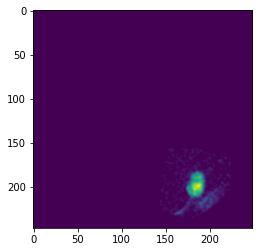

In [5]:
i = 840

dest_size = get_bbox_size(roi)
frame = reverse_crop_and_rotate_frame(clean_frames[i], dest_size, centroids[i], angles[i])
plt.imshow(frame)

In [6]:
#from moseq2_detectron_extract.io.flips import preview_video_from_h5
#preview_video_from_h5(h5_file, r'E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.fromh5.mp4')

In [7]:
def preview_video_from_h5(h5_file: h5py.File, dest: str, dset_name: str = 'moseq', vmin=0, vmax=100, fps=30, batch_size=10, start=None, stop=None):

    total_frames = h5_file['/frames'].shape[0]
    roi = h5_file['/metadata/extraction/roi'][()]
    roi_size = get_bbox_size(roi)

    dset_meta = MetadataCatalog.get(dset_name)
    clean_frames_view = CleanedFramesView(scale=1.5, dset_meta=dset_meta)
    rot_kpt_view = RotatedKeypointsView(scale=1.5, dset_meta=dset_meta)
    arena_view = ArenaView(roi, scale=2.0, vmin=vmin, vmax=vmax, dset_meta=dset_meta)

    video_pipe = PreviewVideoWriter(dest, fps=fps, vmin=vmin, vmax=vmax)

    batches = list(gen_batch_sequence(h5_file['/frames'].shape[0], batch_size, 0, 0))

    for batch, batch_idxs in enumerate(tqdm(batches, desc='batches', total=len(batches))):
        batch_idxs = list(batch_idxs)
        #print(batch_idxs)
        masks = h5_file['/frames_mask'][batch_idxs, ...]
        clean_frames = h5_file['/frames'][batch_idxs, ...]
        centroids = np.stack((
            h5_file['/scalars/centroid_x_px'][batch_idxs],
            h5_file['/scalars/centroid_y_px'][batch_idxs]
        ), axis=1)
        angles = h5_file['/scalars/angle'][batch_idxs]
        rot_keypoints = load_keypoint_data_from_h5(h5_file, coord_system='rotated', units='px')[batch_idxs]
        ref_keypoints = load_keypoint_data_from_h5(h5_file, coord_system='reference', units='px')[batch_idxs]
        

        raw_frames = np.zeros((clean_frames.shape[0], roi_size[1], roi_size[0]), dtype='uint8')
        raw_masks = np.zeros((clean_frames.shape[0], roi_size[1], roi_size[0]), dtype='bool')
        for i in range(clean_frames.shape[0]):
            raw_frames[i] = reverse_crop_and_rotate_frame(clean_frames[i], roi_size, centroids[i], angles[i])
            raw_masks[i] = reverse_crop_and_rotate_frame(masks[i].astype('uint8'), roi_size, centroids[i], angles[i]).astype('bool')

        field_video = arena_view.generate_frames(raw_frames=raw_frames, keypoints=ref_keypoints[:, None, :, :], masks=raw_masks, boxes=None)
        rc_kpts_video = rot_kpt_view.generate_frames(masks=masks, keypoints=rot_keypoints)
        cln_depth_video = clean_frames_view.generate_frames(clean_frames=clean_frames, masks=masks)

        proc_stack = stack_videos([cln_depth_video, rc_kpts_video], orientation='vertical')
        out_video_combined = stack_videos([proc_stack, field_video], orientation='horizontal')
        plt.imshow(field_video[0])
        video_pipe.write_frames(batch_idxs, out_video_combined)
        return

    video_pipe.close()

batches:   0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'dtype'

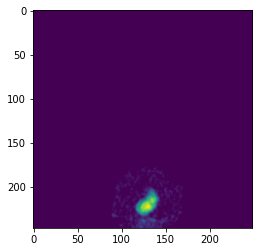

In [8]:
preview_video_from_h5(h5_file, r'E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.fromh5.mp4')